# Investigate solution for Exercise 9.2

The [solution for exercise 9.2](Exercise_09_2_solution.ipynb) is a bit suspicious:

* The achieved accuracy is suspiciously high
* During training there is a sudden drop in the the loss, indicating the model learned to do "something completely different" to find a new minimum
* It seems nescessary to carefully schedule the learning rate to reach this minimum
* It seems always nescessary to use an additional non-RNN transformation to summarize the information about the whole Sequence to achieve best performance. What worked: *Flatten + Dense* (like in the solution) or alternatively *Global average Pooling + Dense* (something that preserves the possibility to feed an arbitrary length sequence)

This notebook investigates possible overfitting to unphysical features of the dataset

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
f = np.load('radio_data.npz')
n_train = 40000

x_train, x_test = f["traces"][:n_train], f["traces"][n_train:]  # measured traces (signal + colored noise)
signals = f["signals"]  # signal part (only available for cosmic-ray events)

labels = (signals.std(axis=-1) != 0).astype(float)  # define training label (1=cosmic event, 0=noise)
y_train, y_test = labels[:n_train], labels[n_train:]

sigma = x_train.std()
x_train /= sigma
x_test /= sigma

You can try 2 different models, the first one from the solution:

`model_with_flatten.h5`

```python
model = keras.models.Sequential()
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True), input_shape=(500,1)))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=True)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation="sigmoid"))
```

the other one as an alternative with `GlobalMaxPooling`:

`model_with_maxpool.h5`

```python
model = keras.models.Sequential()
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True))) # <- made this larger
model.add(layers.GlobalMaxPool1D()) # <- global pooling instead of flatten
model.add(layers.Dense(128, activation="relu")) # <- added this
model.add(layers.Dense(1, activation="sigmoid"))
model.build((None, None, 1))
```


In [6]:
model = tf.keras.models.load_model("model_with_maxpool.h5")

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        263168    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               3

In [5]:
model.evaluate(x_test[:100], y_test[:100])

4/4 [==============================] - 4s 480ms/step - loss: 0.0093 - accuracy: 1.0000


[0.009328240528702736, 1.0]

The accuracy is suspiciously high - maybe the model extracts information from some very specific values in the dataset?

Let's try to disturb them a bit by scaling the numbers with random numbers close to 1 that shouldn't change anything:

In [6]:
def disturbed(x, scale=0.01):
    return x * np.random.normal(size=x.shape, loc=1, scale=scale)

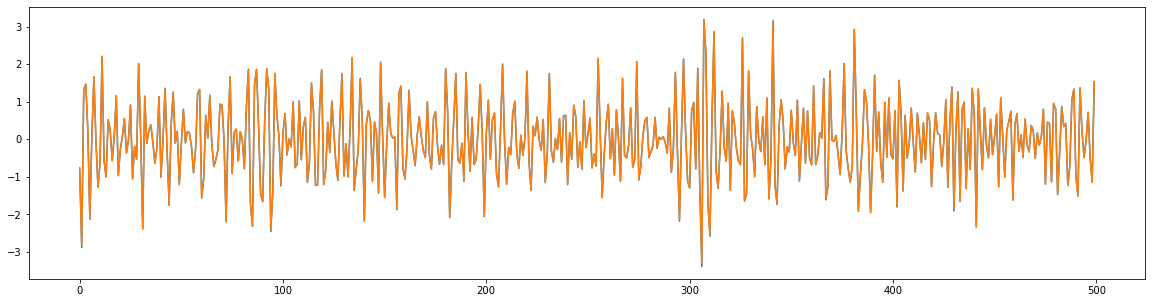

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(x_test[0])
plt.plot(disturbed(x_test[0], scale=0.01))

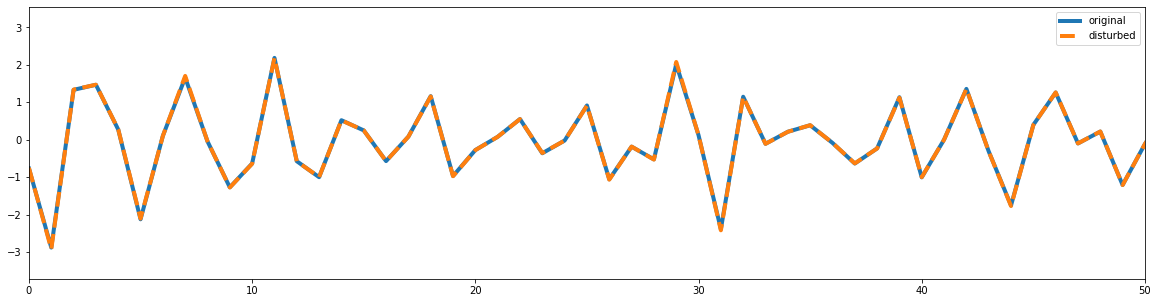

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(x_test[0], label="original", linewidth=4)
plt.plot(disturbed(x_test[0], scale=0.01), linewidth=4, label="disturbed", linestyle="--")
plt.xlim(0, 50)
plt.legend()

In [7]:
y_test[:10]

array([1., 0., 1., 1., 1., 0., 1., 0., 1., 0.])

For signal, there is no significant change:

In [10]:
model(x_test[0:1])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9999045]], dtype=float32)>

In [11]:
model(disturbed(x_test[0:1], scale=0.01))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.99999887]], dtype=float32)>

But for background, suddenly the model will think this is signal when we disturb it:

In [12]:
model(x_test[1:2])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00742291]], dtype=float32)>

In [13]:
model(disturbed(x_test[1:2], scale=0.01))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9999917]], dtype=float32)>

Also interesting: Double peak structure in the standard devations of instances with signal, where there is a quite clear separation for the second peak:

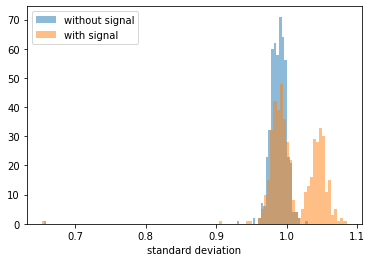

In [14]:
plt.hist(x_test[y_test==0].std(axis=0), bins=100, alpha=0.5, label="without signal");
plt.hist(x_test[y_test==1].std(axis=0), bins=100, alpha=0.5, label="with signal");
plt.xlabel("standard deviation")
plt.legend()

Cutting on this will give an accuracy of around 63%

In [15]:
((x_test.std(axis=1) > 1.02) == (y_test == 1)).mean()

0.6303

One issue may be that the amplitude values don't seem to be all unique, maybe the NN can learn to make use of detecting these specific values?

In [16]:
len(np.unique(x_test[y_test==0]))

467666

In [17]:
len(x_test[y_test==0].ravel())

2491500

And indeed, we find for many amplitude values in the sequence it's even enough to slightly change a single value to get a completely different prediction:

In [8]:
npoints = 30
changed = np.tile(x_test[1], npoints * 16).reshape(16, npoints, -1)
indices = []
for i in range(16):
    index = np.random.randint(0, 500)
    indices.append(index)
    for j, shift in enumerate(np.linspace(-0.01, 0.01, npoints)):
        changed[i, j, index] = x_test[1][index] + shift

In [9]:
results = model(changed.reshape(-1, 500)).numpy().reshape(-1, npoints)

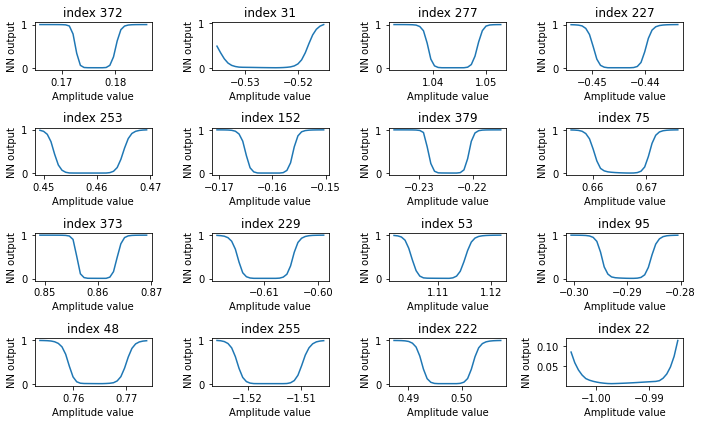

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
for index, values, result, ax in zip(indices, changed, results, axs.ravel()):
    ax.plot(values[:, index], result)
    ax.set_ylabel("NN output")
    ax.set_xlabel("Amplitude value")
    ax.set_title(f"index {index}")
fig.tight_layout()